## Hospital Readmission Rate:  CMS Demo
Evaluating quality of care using random forest regression.

## Table of Contents
1. <a href='#goal'>Problem Statement</a>
2. <a href='#data'>Data Collection</a>
3. <a href='#model1'>Baseline Model #1</a>
4. <a href='#model2'>Baseline Model #2</a>
5. <a href='#model3'>Baseline Model #3</a>
6. <a href='#model4'>Random Forest Model</a>
7. <a href='#model5'>XGBoost Model</a>
8. <a href='#summary'>Summary</a>

In [1]:
import pandas as pd
import numpy as np
import ppscore as pps
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown, display

pd.set_option('max_colwidth', 1000)
pd.set_option('min_rows', 20)
pd.set_option('max_columns', 1000)

pd.options.display.float_format = '{:,.2f}'.format

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from yellowbrick.regressor import prediction_error

/Users/nicolebills/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/nicolebills/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<a id='goal'></a>
## 1. Problem Statement
**Objective**: demonstrate random forest regression as a tool to assess quality of care

**Scenario**: Dashboard user is a hospital administrator or local government official looking to understand the healthcare system in a given locality.  The user has access to data from 2007-2017 and is looking to make predictions for the future.

**Background**: hospital readmission rate can be used as a proxy for quality of care

**Approach**: evaluate random forest regression against baseline models

<a id='data'></a>
## 2. Data Collection
**Dataset**: '[Medicare Geographic Variation](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Geographic-Variation/GV_PUF)' from CMS

In [2]:
data = pd.read_csv('../data/geo_var_puf_rf2.csv',index_col='FIPS_year')

TARGET = 'Hospital Readmission Rate'

In [3]:
data = data.loc[(data['State and County FIPS Code'] != '*')] # Drop aggregate rows
data = data.loc[(~data[TARGET].isna())] # Drop nans

In [4]:
data

,State,County,State and County FIPS Code,Year,Beneficiaries with Part A and Part B,FFS Beneficiaries,MA Beneficiaries,MA Participation Rate,Average Age,Percent Female,Percent Male,Percent Non-Hispanic White,Percent African American,Percent Hispanic,Percent Other/Unknown,Percent Eligible for Medicaid,Average HCC Score,Total Actual Costs,Total Standardized Costs,Total Standardized Risk-Adjusted Costs,Actual Per Capita Costs,Standardized Per Capita Costs,Standardized Risk-Adjusted Per Capita Costs,IP Actual Costs,IP Actual Costs as % of Total Actual Costs,IP Per Capita Actual Costs,IP Per User Actual Costs,IP Standardized Costs,IP Standardized Costs as % of Total Standardized Costs,IP Per Capita Standardized Costs,IP Per User Standardized Costs,IP Users (with a covered stay),% of Beneficiaries Using IP,IP Covered Stays Per 1000 Beneficiaries,IP Covered Days Per 1000 Beneficiaries,Number of Acute Hospital Readmissions,Hospital Readmission Rate,Emergency Department Visits,Emergency Department Visits per 1000 Beneficiaries,% of Beneficiaries with an ED Visit,OP Actual Costs,OP Actual Costs as % of Total Actual Costs,OP Per Capita Actual Costs,OP Per User Actual Costs,OP Standardized Costs,OP Standardized Costs as % of Total Standardized Costs,OP Per Capita Standardized Costs,OP Per User Standardized Costs,# OP Users,% of Beneficiaries Using OP,OP Visits Per 1000 Beneficiaries,ASC Actual Costs,ASC Actual Costs as % of Total Actual Costs,ASC Per Capita Actual Costs,ASC Per User Actual Costs,ASC Standardized Costs,ASC Standardized Costs as % of Total Standardized Costs,ASC Per Capita Standardized Costs,ASC Per User Standardized Costs,# ASC Users,% of Beneficiaries Using ASC,ASC Events Per 1000 Beneficiaries,PAC: SNF Actual Costs,PAC: SNF Actual Costs as % of Total Actual Costs,PAC: SNF Per Capita Actual Costs,PAC: SNF Per User Actual Costs,PAC: SNF Standardized Costs,PAC: SNF Standardized Costs as % of Total Standardized Costs,PAC: SNF Per Capita Standardized Costs,PAC: SNF Per User Standardized Costs,# PAC: SNF Users (with a covered stay),% of Beneficiaries Using PAC: SNF,PAC: SNF Covered Stays Per 1000 Beneficiaries,PAC: SNF Covered Days Per 1000 Beneficiaries,PAC: IRF Actual Costs,PAC: IRF Actual Costs as % of Total Actual Costs,PAC: IRF Per Capita Actual Costs,PAC: IRF Per User Actual Costs,PAC: IRF Standardized Costs,PAC: IRF Standardized Costs as % of Total Standardized Costs,PAC: IRF Per Capita Standardized Costs,PAC: IRF Per User Standardized Costs,# PAC: IRF Users (with a covered stay),% of Beneficiaries Using PAC: IRF,PAC: IRF Covered Stays Per 1000 Beneficiaries,PAC: IRF Covered Days Per 1000 Beneficiaries,PAC: LTCH Actual Costs,PAC: LTCH Actual Costs as % of Total Actual Costs,PAC: LTCH Per Capita Actual Costs,PAC: LTCH Per User Actual Costs,PAC: LTCH Standardized Costs,PAC: LTCH Standardized Costs as % of Total Standardized Costs,PAC: LTCH Per Capita Standardized Costs,PAC: LTCH Per User Standardized Costs,# PAC: LTCH Users (with a covered stay),% of Beneficiaries Using PAC: LTCH,PAC: LTCH Covered Stays Per 1000 Beneficiaries,PAC: LTCH Covered Days Per 1000 Beneficiaries,PAC: HH Actual Costs,PAC: HH Actual Costs as % of Total Actual Costs,PAC: HH Per Capita Actual Costs,PAC: HH Per User Actual Costs,PAC: HH Standardized Costs,PAC: HH Standardized Costs as % of Total Standardized Costs,PAC: HH Per Capita Standardized Costs,PAC: HH Per User Standardized Costs,# PAC: HH Users,% of Beneficiaries Using PAC: HH,PAC: HH Episodes Per 1000 Beneficiaries,PAC: HH Visits Per 1000 Beneficiaries,Hospice Actual Costs,Hospice Actual Costs as % of Total Actual Costs,Hospice Per Capita Actual Costs,Hospice Per User Actual Costs,Hospice Standardized Costs,Hospice Standardized Costs as % of Total Standardized Costs,Hospice Per Capita Standardized Costs,Hospice Per User Standardized Costs,# Hospice Users (with a covered stay),% of Beneficiaries Using Hospice,Hospice Covered Stays Per 1000 Beneficiaries,Hospice Covered Days Per 1000 Beneficiari

<a id='eda'></a>
### 2.1 Exploratory Data Analysis

**Features**:
- *ft*: description

In [5]:
data.describe(include='all')

,State,County,State and County FIPS Code,Year,Beneficiaries with Part A and Part B,FFS Beneficiaries,MA Beneficiaries,MA Participation Rate,Average Age,Percent Female,Percent Male,Percent Non-Hispanic White,Percent African American,Percent Hispanic,Percent Other/Unknown,Percent Eligible for Medicaid,Average HCC Score,Total Actual Costs,Total Standardized Costs,Total Standardized Risk-Adjusted Costs,Actual Per Capita Costs,Standardized Per Capita Costs,Standardized Risk-Adjusted Per Capita Costs,IP Actual Costs,IP Actual Costs as % of Total Actual Costs,IP Per Capita Actual Costs,IP Per User Actual Costs,IP Standardized Costs,IP Standardized Costs as % of Total Standardized Costs,IP Per Capita Standardized Costs,IP Per User Standardized Costs,IP Users (with a covered stay),% of Beneficiaries Using IP,IP Covered Stays Per 1000 Beneficiaries,IP Covered Days Per 1000 Beneficiaries,Number of Acute Hospital Readmissions,Hospital Readmission Rate,Emergency Department Visits,Emergency Department Visits per 1000 Beneficiaries,% of Beneficiaries with an ED Visit,OP Actual Costs,OP Actual Costs as % of Total Actual Costs,OP Per Capita Actual Costs,OP Per User Actual Costs,OP Standardized Costs,OP Standardized Costs as % of Total Standardized Costs,OP Per Capita Standardized Costs,OP Per User Standardized Costs,# OP Users,% of Beneficiaries Using OP,OP Visits Per 1000 Beneficiaries,ASC Actual Costs,ASC Actual Costs as % of Total Actual Costs,ASC Per Capita Actual Costs,ASC Per User Actual Costs,ASC Standardized Costs,ASC Standardized Costs as % of Total Standardized Costs,ASC Per Capita Standardized Costs,ASC Per User Standardized Costs,# ASC Users,% of Beneficiaries Using ASC,ASC Events Per 1000 Beneficiaries,PAC: SNF Actual Costs,PAC: SNF Actual Costs as % of Total Actual Costs,PAC: SNF Per Capita Actual Costs,PAC: SNF Per User Actual Costs,PAC: SNF Standardized Costs,PAC: SNF Standardized Costs as % of Total Standardized Costs,PAC: SNF Per Capita Standardized Costs,PAC: SNF Per User Standardized Costs,# PAC: SNF Users (with a covered stay),% of Beneficiaries Using PAC: SNF,PAC: SNF Covered Stays Per 1000 Beneficiaries,PAC: SNF Covered Days Per 1000 Beneficiaries,PAC: IRF Actual Costs,PAC: IRF Actual Costs as % of Total Actual Costs,PAC: IRF Per Capita Actual Costs,PAC: IRF Per User Actual Costs,PAC: IRF Standardized Costs,PAC: IRF Standardized Costs as % of Total Standardized Costs,PAC: IRF Per Capita Standardized Costs,PAC: IRF Per User Standardized Costs,# PAC: IRF Users (with a covered stay),% of Beneficiaries Using PAC: IRF,PAC: IRF Covered Stays Per 1000 Beneficiaries,PAC: IRF Covered Days Per 1000 Beneficiaries,PAC: LTCH Actual Costs,PAC: LTCH Actual Costs as % of Total Actual Costs,PAC: LTCH Per Capita Actual Costs,PAC: LTCH Per User Actual Costs,PAC: LTCH Standardized Costs,PAC: LTCH Standardized Costs as % of Total Standardized Costs,PAC: LTCH Per Capita Standardized Costs,PAC: LTCH Per User Standardized Costs,# PAC: LTCH Users (with a covered stay),% of Beneficiaries Using PAC: LTCH,PAC: LTCH Covered Stays Per 1000 Beneficiaries,PAC: LTCH Covered Days Per 1000 Beneficiaries,PAC: HH Actual Costs,PAC: HH Actual Costs as % of Total Actual Costs,PAC: HH Per Capita Actual Costs,PAC: HH Per User Actual Costs,PAC: HH Standardized Costs,PAC: HH Standardized Costs as % of Total Standardized Costs,PAC: HH Per Capita Standardized Costs,PAC: HH Per User Standardized Costs,# PAC: HH Users,% of Beneficiaries Using PAC: HH,PAC: HH Episodes Per 1000 Beneficiaries,PAC: HH Visits Per 1000 Beneficiaries,Hospice Actual Costs,Hospice Actual Costs as % of Total Actual Costs,Hospice Per Capita Actual Costs,Hospice Per User Actual Costs,Hospice Standardized Costs,Hospice Standardized Costs as % of Total Standardized Costs,Hospice Per Capita Standardized Costs,Hospice Per User Standardized Costs,# Hospice Users (with a covered stay),% of Beneficiaries Using Hospice,Hospice Covered Stays Per 1000 Beneficiaries,Hospice Covered Days Per 1000 Beneficiari

<a id='preproc'></a>
### 2.2 Preprocessing

In [6]:
predictors_df = pps.predictors(data, TARGET)
X_list = predictors_df['x'].to_list()
X_list = X_list[0:10]
X_list

['IP Covered Stays Per 1000 Beneficiaries',
 'Average HCC Score',
 'State',
 'State and County FIPS Code',
 'IP Covered Days Per 1000 Beneficiaries',
 'Average Age',
 'County',
 '% of Beneficiaries Using Outpatient Dialysis Facility',
 'PAC: LTCH Covered Stays Per 1000 Beneficiaries',
 'Ambulance Events Per 1000 Beneficiaries']

In [7]:
X_list.remove('State')
X_list.remove('County')
X_list

['IP Covered Stays Per 1000 Beneficiaries',
 'Average HCC Score',
 'State and County FIPS Code',
 'IP Covered Days Per 1000 Beneficiaries',
 'Average Age',
 '% of Beneficiaries Using Outpatient Dialysis Facility',
 'PAC: LTCH Covered Stays Per 1000 Beneficiaries',
 'Ambulance Events Per 1000 Beneficiaries']

In [8]:
eval_df = data[[TARGET]+X_list+['Year']]
eval_df = eval_df.fillna(-999)

In [9]:
test_df = eval_df[eval_df.Year == 2018]
train_df = eval_df[eval_df.Year != 2018]

In [10]:
X_train = train_df[X_list].values
y_train = train_df[TARGET].values
X_test = test_df[X_list].values
y_test = test_df[TARGET].values

In [11]:
baselines = test_df.copy()

<a id='model1'></a>
## 3. Baseline Model #1 - Means

In [12]:
means = ( pd.pivot_table(data, index='State and County FIPS Code', values = TARGET, aggfunc=np.mean)
           .rename({'Hospital Readmission Rate':'mean_readmission'}, axis=1) )

baselines = baselines.merge(means, how='left', on='State and County FIPS Code')


In [13]:
y_pred = baselines['mean_readmission']

In [14]:
display(Markdown("#### Metrics"))
print('- Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('- Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('- R Squared:', metrics.r2_score(y_test, y_pred))

#### Metrics

- Mean Absolute Error: 1.5009798959686735
- Mean Squared Error: 4.29552610560712
- R Squared: 0.511018506232807


<a id='model2'></a>
## 4. Baseline Model #2 - Status Quo

In [15]:
status_quo = ( data[['State and County FIPS Code','Hospital Readmission Rate']][data.index.map(lambda x: '2017' == x[-4:])]
               .rename({'Hospital Readmission Rate':'2017_readmission'}, axis=1) )
baselines = baselines.merge(status_quo, how='left', on='State and County FIPS Code')

In [16]:
y_pred = baselines['2017_readmission'].fillna(baselines['2017_readmission'].mean())

In [17]:
display(Markdown("#### Metrics"))
print('- Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('- Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('- R Squared:', metrics.r2_score(y_test, y_pred))

#### Metrics

- Mean Absolute Error: 1.7766652337669426
- Mean Squared Error: 6.8735512286309675
- R Squared: 0.21754884858597467


<a id='model3'></a>
## 5. Baseline Model #3 - Linear Regression

In [18]:
linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)
baselines['linreg_readmission'] = y_pred

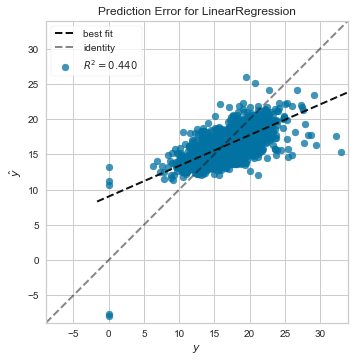

In [19]:
visualizer = prediction_error(linreg, X_train, y_train, X_test, y_test, size=(400,400))

In [20]:
display(Markdown("#### Metrics"))
print('- Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('- Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('- R Squared:', metrics.r2_score(y_test, y_pred))

#### Metrics

- Mean Absolute Error: 1.6291531894475915
- Mean Squared Error: 4.916823695412079
- R Squared: 0.4402930546658338


### Update df

In [21]:
def calc_diff(x_readmission):
    return abs((baselines[x_readmission] - baselines[TARGET]) / baselines[TARGET])

baselines['perc_diff_mean'] = calc_diff('mean_readmission')
baselines['perc_diff_2017'] = calc_diff('2017_readmission')
baselines['perc_diff_linreg'] = calc_diff('linreg_readmission')

In [22]:
baselines

,Hospital Readmission Rate,IP Covered Stays Per 1000 Beneficiaries,Average HCC Score,State and County FIPS Code,IP Covered Days Per 1000 Beneficiaries,Average Age,% of Beneficiaries Using Outpatient Dialysis Facility,PAC: LTCH Covered Stays Per 1000 Beneficiaries,Ambulance Events Per 1000 Beneficiaries,Year,mean_readmission,2017_readmission,linreg_readmission,perc_diff_mean,perc_diff_2017,perc_diff_linreg
0,15.22,200.00,0.87,02020,"1,265.00",71.00,1.14,4.00,226.00,2018,14.46,15.21,15.04,0.05,0.00,0.01
1,16.81,300.00,0.82,02050,"1,560.00",71.00,-999.00,-999.00,399.00,2018,14.19,10.22,17.00,0.16,0.39,0.01
2,13.13,270.00,0.87,02070,"1,285.00",71.00,-999.00,0.00,342.00,2018,15.51,17.92,16.02,0.18,0.36,0.22
3,12.35,154.00,0.79,02090,928.00,69.00,0.51,-999.00,248.00,2018,12.86,11.58,14.04,0.04,0.06,0.14
4,15.94,146.00,0.73,02100,769.00,72.00,0.00,-999.00,207.00,2018,16.81,nan,12.75,0.05,nan,0.20
5,13.08,181.00,0.75,02110,"1,033.00",70.00,0.57,-999.00,289.00,2018,14.20,10.66,14.38,0.09,0.19,0.10
6,15.13,194.00,0.78,02122,"1,010.00",71.00,0.37,2.00,197.00,2018,14.74,13.89,14.22,0.03,0.08,0.06
7,20.19,252.00,0.83,02130,"1,268.00",71.00,-999.00,-999.00,373.00,2018,16.93,19.08,15.71,0.16,0.05,0.22
8,18.22,187.00,0.81,02150,858.00,71.00,0.79,-999.00,207.00,2018,15.95,15.68,13.86,0.12,0.14,0.24
9,16.54,291.00,0.86,02158,"1,395.00",70.00,-999.00,0.00,331.00,2018,16.11,17.27,16.74,0.03,0.04,0.01


<a id='model4'></a>
## 6. Random Forest 

In [23]:
regr = RandomForestRegressor(random_state=42, n_estimators = 800, min_samples_split=5)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

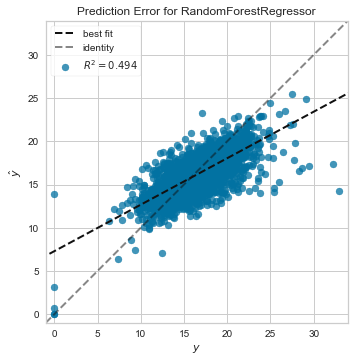

In [24]:
visualizer = prediction_error(regr, X_train, y_train, X_test, y_test, size=(400,400))

In [25]:
display(Markdown("#### Metrics"))
print('- Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('- Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('- R Squared:', metrics.r2_score(y_test, y_pred))

#### Metrics

- Mean Absolute Error: 1.5206947626209621
- Mean Squared Error: 4.441524509578805
- R Squared: 0.4943987684157066


In [26]:
baselines['rf_readmission'] = y_pred
baselines['perc_diff_rf'] = calc_diff('rf_readmission')

<a id='model5'></a>
## 7. XGBoost

In [27]:
regr = xgb.XGBRegressor(random_state=42, n_estimators = 800, min_samples_split=5)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

[12:15:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




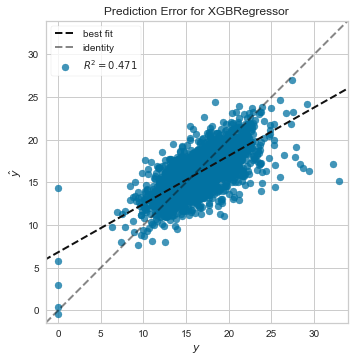

In [28]:
visualizer = prediction_error(regr, X_train, y_train, X_test, y_test, size=(400,400))

In [29]:
display(Markdown("#### Metrics"))
print('- Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('- Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('- R Squared:', metrics.r2_score(y_test, y_pred))

#### Metrics

- Mean Absolute Error: 1.5613260987947841
- Mean Squared Error: 4.649654554225539
- R Squared: 0.4707062712390869


In [30]:
baselines['xgb_readmission'] = y_pred
baselines['perc_diff_xgb'] = calc_diff('xgb_readmission')

<a id='summary'></a>
## 8. Summary

In [41]:
baselines[['perc_diff_rf', 'perc_diff_xgb', 'perc_diff_mean', 'perc_diff_2017', 'perc_diff_linreg']].dropna().mean()

perc_diff_rf       0.09
perc_diff_xgb      0.09
perc_diff_mean     0.09
perc_diff_2017     0.11
perc_diff_linreg   0.10
dtype: float64